<a href="https://colab.research.google.com/github/hBar2013/DS-Unit-2-Linear-Models/blob/master/kim_lowry_tanzania_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install category_encoders

In [0]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission (1).csv to sample_submission (1).csv


In [0]:
%matplotlib inline
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels



In [0]:
!unzip test_features.csv.zip

Archive:  test_features.csv.zip
  inflating: test_features.csv       


In [0]:
!unzip train_features.csv.zip

Archive:  train_features.csv.zip
  inflating: train_features.csv      


In [0]:
!unzip train_labels.csv.zip

Archive:  train_labels.csv.zip
  inflating: train_labels.csv        


In [0]:
train_features_file = 'train_features.csv'
train_labels_file = 'train_labels.csv'
test_features_file = 'test_features.csv'
sumbission_sample_file = 'sample_submission (1).csv'

sample_submission = pd.read_csv(sumbission_sample_file)
train_feat = pd.read_csv(train_features_file)
train_labels = pd.read_csv(train_labels_file)
test_feat = pd.read_csv(test_features_file)

In [0]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
train_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [7]:
X_train = train_feat
y_train = train_labels['status_group']

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.80, test_size=0.20, 
    stratify=y_train, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [0]:
def clean_data(X, cats, nums):
    """
    Encodes a specified list of columns or all columns if None.
    """
    X = X.copy()
    
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    for num in nums:
       X[num] = X[num].replace(0, np.nan)
    
    for cat in cats:
        X[cat] = X[cat].fillna('MISSING')
        
   
    return X

In [0]:
#def model_selection(X_train, y_train,X_val, y_val, estimator):
#    """
#    Test various estimators.
#    """
   
#    pipeline = make_pipeline(
#          ce.OrdinalEncoder(),
#          SimpleImputer(strategy='mean'),
#          estimator
#    )

#    pipeline.fit(X_train, y_train)
#    y_pred = pipeline.predict(X_val)
    
#    labels = unique_labels(y_val)
#    columns = [f'Predicted {label}' for label in labels]
#    index = [f'Actual {label}' for label in labels]
#    table = pd.DataFrame(confusion_matrix(y_val, y_pred), 
#                         columns=columns, index=index)
     
#    print(accuracy_score(y_val, y_pred), 
#            classification_report(y_val, y_pred),
#            sns.heatmap(table, annot=True, fmt='d', cmap='viridis')
#           )


In [0]:
cat_features = ['payment_type','waterpoint_type', 'quantity','extraction_type',
                'permit', 'management']
num_features   = ['construction_year', 'population', 'latitude', 'longitude',
                  'gps_height', 'region_code', 'district_code']

features = cat_features + num_features

In [0]:
X_train = clean_data(X_train, cat_features, num_features)
X_val = clean_data(X_val, cat_features, num_features)
test_feat = clean_data(test_feat, cat_features, num_features)

In [0]:
X_train_subset = X_train[features]
X_val_subset = X_val[features]
test_subset = test_feat[features]

In [0]:
estimator = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)

0.8035353535353535                          precision    recall  f1-score   support

             functional       0.81      0.88      0.84      6452
functional needs repair       0.49      0.32      0.38       863
         non functional       0.84      0.78      0.81      4565

               accuracy                           0.80     11880
              macro avg       0.71      0.66      0.68     11880
           weighted avg       0.80      0.80      0.80     11880
 AxesSubplot(0.125,0.125;0.62x0.755)


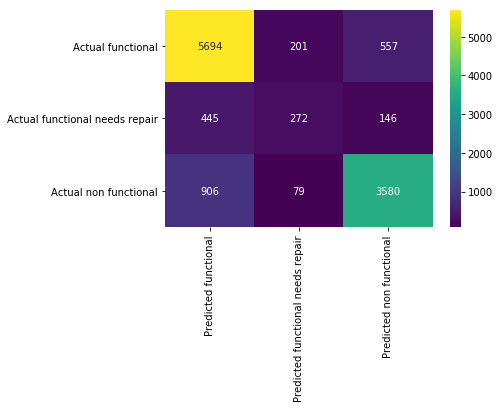

In [0]:

pipeline = make_pipeline(
      ce.OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      estimator
)

pipeline.fit(X_train_subset, y_train)
y_pred = pipeline.predict(X_val_subset)
    
labels = unique_labels(y_val)
columns = [f'Predicted {label}' for label in labels]
index = [f'Actual {label}' for label in labels]
table = pd.DataFrame(confusion_matrix(y_val, y_pred), 
                     columns=columns, index=index)
     
print(
    accuracy_score(y_val, y_pred), 
    classification_report(y_val, y_pred),
    sns.heatmap(table, annot=True, fmt='d', cmap='viridis')
 )

    

In [0]:
y_pred = pipeline.predict(test_subset)

In [0]:
from xgboost import XGBClassifier

In [15]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train_subset)
X_val_processed = processor.transform(X_val_subset)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='merror', 
          early_stopping_rounds=10)

[0]	validation_0-merror:0.302799	validation_1-merror:0.302778
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.293582	validation_1-merror:0.293855
[2]	validation_0-merror:0.293582	validation_1-merror:0.293855
[3]	validation_0-merror:0.293582	validation_1-merror:0.293855
[4]	validation_0-merror:0.293519	validation_1-merror:0.294108
[5]	validation_0-merror:0.292866	validation_1-merror:0.29335
[6]	validation_0-merror:0.293077	validation_1-merror:0.293182
[7]	validation_0-merror:0.29314	validation_1-merror:0.293098
[8]	validation_0-merror:0.293077	validation_1-merror:0.293434
[9]	validation_0-merror:0.292971	validation_1-merror:0.292929
[10]	validation_0-merror:0.292866	validation_1-merror:0.292761
[11]	validation_0-merror:0.292193	validation_1-merror:0.292677
[12]	validation_0-merror:0.292319	validation_1-merror:0.291835
[13]	validation_0-merror:0.291

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
test_processed = processor.transform(test_subset)

In [0]:
y_pred2 = model.predict(test_processed)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred2
submission.to_csv('kel-submission-08.csv', index=False)

In [21]:
!head kel-submission-08.csv

id,status_group
50785,non functional
51630,functional
17168,non functional
45559,non functional
49871,functional
52449,functional
24806,functional
28965,non functional
36301,functional


In [0]:
from google.colab import files
files.download('kel-submission-08.csv')